## Bilayer unit domain. Sigma optimisation

In [1132]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [1133]:
# Define element size for the mesh refinement
h_i = [0.125/4,   # N=2
       0.125/8,   # N=3
       0.125/16,] # N=4
    # 0.0625 / 4,
    # 0.0625 / 8] 

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4
# sigma_0 = 1 #0.484375

# Solver configuration
requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [1134]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-35.5j)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()
    
    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [1135]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof):
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real mayor que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    # Seleccionar el n-ésimo eigenvalor filtrado
    omega_value, vrA = eigenvalues[selected_index]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [omega_value, p_h, v_h]  # Return eigenfunction and eigenvalue

In [1136]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

In [1137]:
def get_exact_eigenpair(solver, selected_index, Q, V, x_hat, sigma_0_piecewise, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    # p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    # p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (np.where(x[0]>=Lx, x_hat(x,w),x[0]) - l_inner))
    # p = lambda x: np.where(x[0] == Lx + pml_thickness, 0., np.where(x[0] >= l_inner, p_2(x), p_1(x)))
    x_value= lambda x: np.where(x[0] <= Lx, x[0], x_hat(x, w))
    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_value(x) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))
    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_0_piecewise))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)* np.exp(1j * w / vel_media_2 * (np.where(x[0]>=Lx, x_hat(x,w),x[0]) - l_inner))* gamma_x(x, w))
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

quadratic

In [1138]:
degree=[3,2]  # Polynomial degree for pressure and velocity

In [1139]:
sigma_sweep_piecewise=np.linspace(5., 65., 15)  # Sweep of PML parameter sigma_0

In [1140]:
def get_closer_approx_eig(exact, solver, Q, V, dof, number_of_values=0):
    error = []
    for j in np.arange(number_of_values):
        error.append(np.abs(exact - get_approx_eigenpair(solver, j, Q, V, dof)[0]) / np.abs(exact))

    index_closest_eig = np.argmin(error)
    return get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[0], get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[1], get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[2], index_closest_eig

In [1141]:
exact_omega = [None] * 6 
for j in np.arange(1, 7, 1):
    exact_omega[j-1] = get_exact_eigenvalue(j)

In [1142]:
def group_by_real_part_with_indices(eigenvalues, tolerance=1):
    groups = []
    indices_groups = []
    for row in eigenvalues:
        row_indices = []
        for idx, eig in enumerate(row):
            added = False
            for i, group in enumerate(groups):
                if abs(group[0].real - eig.real) < tolerance:
                    group.append(eig)
                    indices_groups[i].append(idx)
                    added = True
                    break
            if not added:
                groups.append([eig])
                indices_groups.append([idx])
        row_indices.append(indices_groups)
    return groups, indices_groups

In [ ]:
# Initialize lists to store the approximated eigenpairs
approx_piecewise = [[0 for _ in range(6)] for _ in range(len(sigma_sweep_piecewise))]
approx_eigv_p = [[0 for _ in range(6)] for _ in range(len(sigma_sweep_piecewise))]
approx_eigv_v = [[0 for _ in range(6)] for _ in range(len(sigma_sweep_piecewise))]
for i,sigma_0_piecewise in zip(range(len(sigma_sweep_piecewise)),sigma_sweep_piecewise):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[0]), [0, Lx + pml_thickness])
    # Define piecewise sigma function
    sigma_x_piecewise=lambda x: conditional(x[0] > Lx, sigma_0_piecewise, 0.0)
    # Define solver for piecewise PML
    [solver_piecewise, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_piecewise)
    [exact_eig_0, exact_eigv_0_p, exact_eigv_0_v]=get_exact_eigenpair(solver_piecewise, 1, Q_, V_, lambda x, w: x[0] + (1j/w)* (x[0]-Lx)*sigma_0_piecewise, sigma_0_piecewise, lambda x, w: (1j / w) * sigma_0_piecewise)
    [exact_eig_3, exact_eigv_3_p, exact_eigv_3_v]=get_exact_eigenpair(solver_piecewise, 4, Q_, V_, lambda x, w: x[0] + (1j/w)* (x[0]-Lx)*sigma_0_piecewise, sigma_0_piecewise, lambda x, w: (1j / w) * sigma_0_piecewise)
    for j in np.arange(0, 6,1):
        [approx_piecewise[i][j], approx_eigv_p[i][j],approx_eigv_v[i][j], index] = get_closer_approx_eig(exact_omega[j], solver_piecewise, Q_, V_, dof_, 15)
        
def remove_close_duplicates_with_indices(row, tol=1e-10):
    seen = set()
    unique = []
    indices = []
    for idx, z in enumerate(row):
        key = (round(z.real / tol) * tol, round(z.imag / tol) * tol)
        if key not in seen:
            seen.add(key)
            unique.append(z)
            indices.append(idx)
    return unique, indices

for i in range(len(approx_piecewise)):
    cleaned, indices = remove_close_duplicates_with_indices(approx_piecewise[i], tol=1e-10)
    
    # Actualiza os autovalores
    approx_piecewise[i] = sorted(cleaned, key=lambda x: x.real)
    
    # Aplica os mesmos índices para p e v
    approx_eigv_p[i] = [approx_eigv_p[i][j] for j in indices]
    approx_eigv_v[i] = [approx_eigv_v[i][j] for j in indices]


In [ ]:
# Agrupa los eigenvalores y obtiene los índices
groups_piecewise_eig, indices_groups = group_by_real_part_with_indices(approx_piecewise)

In [ ]:
# Agrupa los primeros, segundos, terceros, etc. de approx_eigv_p[i] para i en range(len(approx_eigv_p))
grouped_eigv_p = [[approx_eigv_p[i][j] for i in range(len(approx_eigv_p))] for j in range(len(approx_eigv_p[0]))]

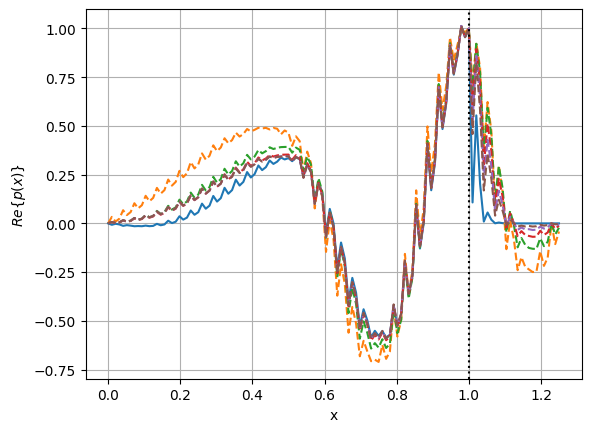

In [ ]:
x = np.linspace(0, 1.25, len(grouped_eigv_p[0][0].x.array))
index_x_1 = np.where(np.isclose(x, 1.0))[0][0]
plt.plot(x,exact_eigv_0_p.x.array/exact_eigv_0_p.x.array[index_x_1],'-')
plt.plot(x,np.real(grouped_eigv_p[0][0].x.array/grouped_eigv_p[0][0].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[0][1].x.array/grouped_eigv_p[0][1].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[0][2].x.array/grouped_eigv_p[0][2].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[0][3].x.array/grouped_eigv_p[0][3].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[0][4].x.array/grouped_eigv_p[0][4].x.array[index_x_1]),'--')
# plt.plot(x,exact_eigv_0_p.x.array,'-')
# plt.plot(x,np.real(grouped_eigv_p[0][0].x.array),'--')
# plt.plot(x,np.real(grouped_eigv_p[0][1].x.array),'--')
# plt.plot(x,np.real(grouped_eigv_p[0][2].x.array),'--')
# plt.plot(x,np.real(grouped_eigv_p[0][3].x.array),'--')
# plt.plot(x,np.real(grouped_eigv_p[0][4].x.array),'--')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$Re\{p(x)\}$')
plt.axvline(x=1, color='k', linestyle='dotted')
# plt.axhline(y=1, color='r', linestyle='dotted')


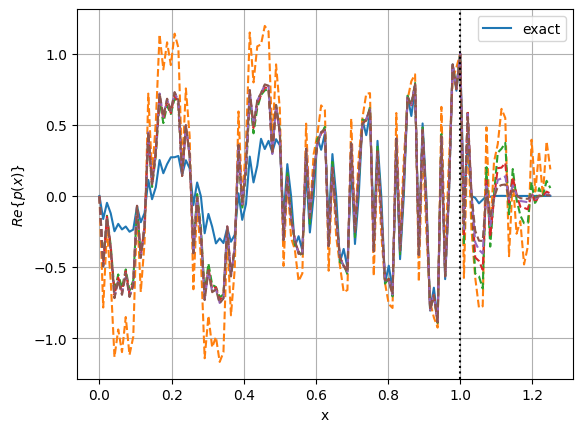

In [ ]:
x = np.linspace(0, 1.25, len(grouped_eigv_p[3][0].x.array))
plt.plot(x,exact_eigv_3_p.x.array/exact_eigv_3_p.x.array[index_x_1],'-', label='exact')
plt.plot(x,np.real(grouped_eigv_p[3][0].x.array/grouped_eigv_p[3][0].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[3][1].x.array/grouped_eigv_p[3][1].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[3][2].x.array/grouped_eigv_p[3][2].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[3][3].x.array/grouped_eigv_p[3][3].x.array[index_x_1]),'--')
plt.plot(x,np.real(grouped_eigv_p[3][4].x.array/grouped_eigv_p[3][4].x.array[index_x_1]),'--')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$Re\{p(x)\}$')
plt.axvline(x=1, color='k', linestyle='dotted')
plt.legend()
# plt.axhline(y=1, color='r', linestyle='dotted')


(12.566370614359172-2.197224577336219j)
(25.132741228718345-2.197224577336219j)
(37.69911184307752-2.197224577336219j)
(50.26548245743669-2.197224577336219j)


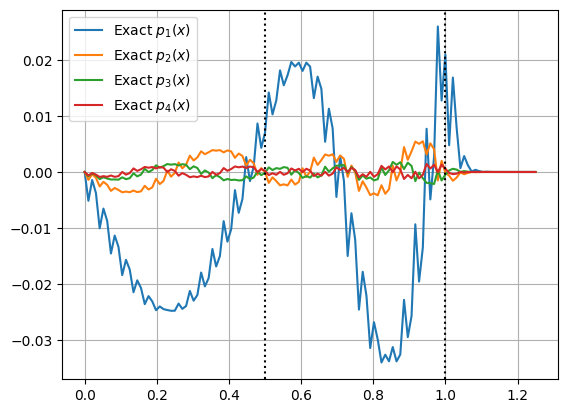

In [ ]:
for i in range(1,5):
    [exact_eig, exact_eigv_p, exact_eigv_v]=get_exact_eigenpair(solver_piecewise, i, Q_, V_, lambda x, w: x[0] + (1j/w)* (x[0]-Lx)*sigma_0_piecewise, sigma_0_piecewise, lambda x, w: (1j / w) * sigma_0_piecewise)
    plt.plot(x,exact_eigv_p.x.array,'-', label=f'Exact $p_{i}(x)$')
    print(exact_eig)
    
plt.legend()
plt.grid(True)
plt.axvline(x=1, color='k', linestyle='dotted')
plt.axvline(x=0.5, color='k', linestyle='dotted')


In [ ]:
[exact_eig_0, exact_eigv_0_p, exact_eigv_0_v]=get_exact_eigenpair(solver_piecewise, 1, Q_, V_, lambda x, w: x[0] + (1j/w)* (x[0]-Lx)*sigma_0_piecewise, sigma_0_piecewise, lambda x, w: (1j / w) * sigma_0_piecewise)

[exact_eig_2, exact_eigv_2_p, exact_eigv_2_v]=get_exact_eigenpair(solver_piecewise, 3, Q_, V_, lambda x, w: x[0] + (1j/w)* (x[0]-Lx)*sigma_0_piecewise, sigma_0_piecewise, lambda x, w: (1j / w) * sigma_0_piecewise)


In [ ]:
groups_piecewise_eig[2], exact_omega[2]

([(37.60500511022307-0.9612979692723674j),
  (37.429056804482286-1.668411646124849j),
  (37.205866595418634-1.9262635864281545j),
  (37.15405487286563-1.9470490018245852j),
  (37.148535981550346-1.9483409238018414j),
  (37.14779030142413-1.9481803817847254j),
  (37.14732778058171-1.9479566510308584j),
  (37.14671842989118-1.9478880627890796j),
  (37.1459612156031-1.9480801488621313j),
  (37.1451210193513-1.948617668114181j),
  (37.144288215991565-1.949569529272717j),
  (37.14357006862122-1.9509873695683615j),
  (37.14308602534521-1.9529049433909225j),
  (37.14296437990206-1.9553383141185057j),
  (37.14333997374933-1.9582862711931985j)],
 np.complex128(37.69911184307752-2.197224577336219j))

In [ ]:
rel_error_eig_0_piecewise_n_3 = abs((groups_piecewise_eig[0] - exact_omega[0])) / np.abs(exact_omega[0])
rel_error_eigv_0_piecewise_n_3 = [
	np.linalg.norm(p.x.array[0:index_x_1] - exact_eigv_0_p.x.array[0:index_x_1]) / np.linalg.norm(exact_eigv_0_p.x.array[0:index_x_1])
	for p in grouped_eigv_p[0]
]

rel_error_eig_2_piecewise_n_3 = abs((groups_piecewise_eig[2] - exact_omega[2])) / np.abs(exact_omega[2])
rel_error_eigv_2_piecewise_n_3 = [
	np.linalg.norm(p.x.array[0:index_x_1] - exact_eigv_2_p.x.array[0:index_x_1]) / np.linalg.norm(exact_eigv_2_p.x.array[0:index_x_1])
	for p in grouped_eigv_p[2]
]

# Calcula el error relativo para el primer grupo de eigenvalores
# rel_error_eig_1_piecewise_n_3=abs((groups_piecewise[3] - exact_omega[3])) / np.abs(exact_omega[3]) 

In [ ]:
# exact_omega, groups_piecewise_eig[0][0], groups_piecewise_eig[1][0], groups_piecewise_eig
# [2][0], groups_piecewise_eig[3][0], groups_piecewise_eig[4][0]

In [ ]:
# rel_error_eig_0_piecewise_n_4=abs((groups_piecewise[0] - exact_omega[0])) / np.abs(exact_omega[0]) 
# rel_error_eig_1_piecewise_n_4=abs((groups_piecewise[3] - exact_omega[3])) / np.abs(exact_omega[3]) 

In [ ]:
rel_error_eigv_0_piecewise_n_3

[np.float64(0.5344520015368346),
 np.float64(0.2617003730298803),
 np.float64(0.11103675380491806),
 np.float64(0.09470683155920882),
 np.float64(0.09395083363436776),
 np.float64(0.0938737223799219),
 np.float64(0.09382893994705215),
 np.float64(0.09375592460641081),
 np.float64(0.09363748059116254),
 np.float64(0.09346066981872408),
 np.float64(0.09321421303276524),
 np.float64(0.09288946107322389),
 np.float64(0.09248186844273741),
 np.float64(0.09199271802316386),
 np.float64(12.210540524090623)]

In [ ]:
rel_error_total_0_piecewise_n_3=rel_error_eigv_0_piecewise_n_3+rel_error_eig_0_piecewise_n_3
rel_error_total_2_piecewise_n_3=rel_error_eigv_2_piecewise_n_3+rel_error_eig_2_piecewise_n_3

ValueError: operands could not be broadcast together with shapes (15,) (14,) 

In [ ]:
rel_error_total_0_piecewise_n_3

array([0.63081884, 0.10562393, 0.10449553, 0.10409801, 0.10303477])

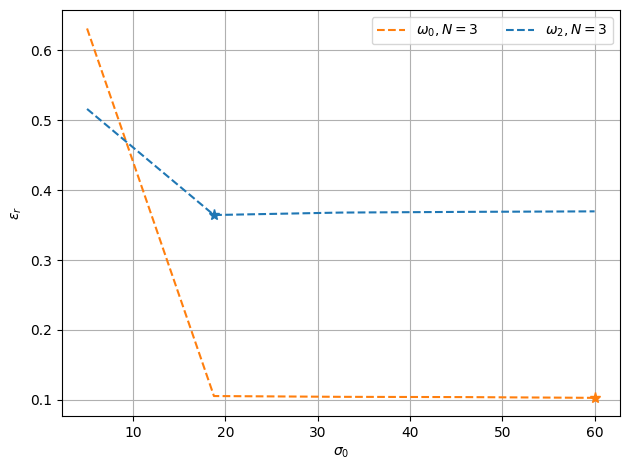

In [ ]:
import matplotlib.pyplot as plt

# Definir colores manualmente (puedes elegir otros o usar un colormap como plt.cm.tab10)
colors = ['tab:green', 'tab:orange', 'tab:blue']  # uno por eig

# N=3, eig 0
plt.plot(sigma_sweep_piecewise, rel_error_total_0_piecewise_n_3, color=colors[1], linestyle='--', label='$\omega_0, N=3$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_total_0_piecewise_n_3)],
    rel_error_total_0_piecewise_n_3[np.argmin(rel_error_total_0_piecewise_n_3)],
    '*',
    color=colors[1],
    markersize=8,
)

# N=3, eig 0
plt.plot(sigma_sweep_piecewise, rel_error_total_2_piecewise_n_3, color=colors[2], linestyle='--', label='$\omega_2, N=3$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_total_2_piecewise_n_3)],
    rel_error_total_2_piecewise_n_3[np.argmin(rel_error_total_2_piecewise_n_3)],
    '*',
    color=colors[2],
    markersize=8,
)

plt.xlabel('$\sigma_0$')
plt.ylabel(r'$\epsilon_r$')
plt.grid(True)
plt.legend(ncol=2)
# plt.ylim([0.012,0.013])
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Definir colores manualmente (puedes elegir otros o usar un colormap como plt.cm.tab10)
colors = ['tab:green', 'tab:orange', 'tab:blue']  # uno por eig

# N=2, eig 0
plt.plot(sigma_sweep_piecewise, rel_error_eig_0_piecewise_n_2, color=colors[0], linestyle='--', label='$\omega_3, N=2$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_eig_0_piecewise_n_2)],
    rel_error_eig_0_piecewise_n_2[np.argmin(rel_error_eig_0_piecewise_n_2)],
    '*',
    color=colors[0],
    markersize=8,
)

# N=3, eig 0
plt.plot(sigma_sweep_piecewise, rel_error_eig_0_piecewise_n_3, color=colors[1], linestyle='--', label='$\omega_3, N=3$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_eig_0_piecewise_n_3)],
    rel_error_eig_0_piecewise_n_3[np.argmin(rel_error_eig_0_piecewise_n_3)],
    '*',
    color=colors[1],
    markersize=8,
)
# N=4, eig 0
plt.plot(sigma_sweep_piecewise, rel_error_eig_0_piecewise_n_4, color=colors[2], linestyle='--', label='$\omega_3, N=4$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_eig_0_piecewise_n_4)],
    rel_error_eig_0_piecewise_n_4[np.argmin(rel_error_eig_0_piecewise_n_4)],
    '*',
    color=colors[2],
    markersize=8,
)


# N=2, eig 1
plt.plot(sigma_sweep_piecewise, rel_error_eig_1_piecewise_n_2, color=colors[0], linestyle=':', label='$\omega_3, N=2$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_eig_1_piecewise_n_2)],
    rel_error_eig_1_piecewise_n_2[np.argmin(rel_error_eig_1_piecewise_n_2)],
    '*',
    color=colors[0],
    markersize=8,
)

# N=3, eig 1
plt.plot(sigma_sweep_piecewise, rel_error_eig_1_piecewise_n_3, color=colors[1], linestyle=':', label='$\omega_3, N=3$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_eig_1_piecewise_n_3)],
    rel_error_eig_1_piecewise_n_3[np.argmin(rel_error_eig_1_piecewise_n_3)],
    '*',
    color=colors[1],
    markersize=8,
)

# N=4, eig 1
plt.plot(sigma_sweep_piecewise, rel_error_eig_1_piecewise_n_4, color=colors[2], linestyle=':', label='$\omega_3, N=4 $')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_eig_1_piecewise_n_4)],
    rel_error_eig_1_piecewise_n_4[np.argmin(rel_error_eig_1_piecewise_n_4)],
    '*',
    color=colors[2],
    markersize=8,
)

plt.xlabel('$\sigma_0$')
plt.ylabel(r'$\epsilon_r$')
plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

NameError: name 'rel_error_eig_0_piecewise_n_2' is not defined